In [4]:
import numpy as np 
import pandas as pd 
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import folium
from folium import Rectangle
from branca.colormap import linear
from collections import defaultdict


# ==============================
# 1. Setup
# ==============================

# Path to satellite images
base_path = '/kaggle/input/gaza-before-and-after-2/Gaza Before and After/images'
# War start date
war_start = datetime(2023, 10, 7)

#The war started on 7 oct 2023 so I want to classify the images to pre,start,post the war 
#The images named like this 2023-01-01.png
#I opened random images found that some images total black or has white spots so i will remove them
#It's easier to dected light changes with grayscale images

In [ ]:
# ==============================
# 2. Preprocessing
# ==============================

# Check if image is valid based on brightness (to remove black/white images)
# Threshold 20 is chosen to exclude very dark images where meaningful content is likely missing
def is_image_valid(image_path, threshold=20):
    try:
        img = Image.open(image_path).convert('L')
        return np.array(img).mean() > threshold
    except Exception as e:
        print(f"❌ Error loading image: {image_path} | {e}")
        return False


# Extract section name from image path
def get_section_name(path):
    for part in path.split('/'):
        if part.startswith('section_'):
            return part
    return None

In [ ]:
# ==============================
# 3. Organize Valid Images by Section
# ==============================
section_images_dict = defaultdict(list)

for dirpath, _, filenames in os.walk(base_path):
    for file in filenames:
        if file.endswith('.png'):
            try:
                date_str = file.replace('.png', '')
                img_date = datetime.strptime(date_str, '%Y-%m-%d')
                full_path = os.path.join(dirpath, file)

                if is_image_valid(full_path):
                    section = get_section_name(full_path)
                    if section:
                        section_images_dict[section].append((img_date, full_path))
            except Exception as e:
                print(f"❌ Error processing {file} | {e}")

In [ ]:
# ==============================
# 4. Image Change Detection
# ==============================

# Compare consecutive images (pre-war & war-start)def pairwise_temporal_analysis(section_images_dict, war_start):
    results = []
    for section, image_list in section_images_dict.items():
        sorted_images = sorted(image_list, key=lambda x: x[0])
        for i in range(len(sorted_images) - 1):
            date1, path1 = sorted_images[i]
            date2, path2 = sorted_images[i+1]
            try:
                img1 = Image.open(path1).convert('L')
                img2 = Image.open(path2).convert('L')
                if img1.size != img2.size:
                    img2 = img2.resize(img1.size)
                diff = np.abs(np.array(img2) - np.array(img1))
                score = diff.mean()

                if date1 < war_start and date2 < war_start:
                    phase = 'pre-war'
                elif date1 < war_start <= date2:
                    phase = 'war-start'
                else:
                    continue  # skip post-war for this logic

                results.append({
                    'section': section,
                    'date_1': date1.date(),
                    'date_2': date2.date(),
                    'change_score': score,
                    'phase': phase
                })
            except:
                continue
    return pd.DataFrame(results)


# Compare every post-war image to last pre-war imagedef postwar_vs_last_pre_analysis(section_images_dict, war_start):
    results = []
    for section, image_list in section_images_dict.items():
        pre = [(d, p) for d, p in image_list if d < war_start]
        post = [(d, p) for d, p in image_list if d > war_start]
        if not pre or not post:
            continue
        pre_date, pre_path = sorted(pre, key=lambda x: x[0])[-1]
        pre_img = Image.open(pre_path).convert('L')
        pre_np = np.array(pre_img)

        for post_date, post_path in sorted(post, key=lambda x: x[0]):
            try:
                post_img = Image.open(post_path).convert('L')
                if post_img.size != pre_img.size:
                    post_img = post_img.resize(pre_img.size)
                diff = np.abs(np.array(post_img) - pre_np)
                score = diff.mean()
                results.append({
                    'section': section,
                    'date_1': pre_date.date(),
                    'date_2': post_date.date(),
                    'change_score': score,
                    'phase': 'post-war'
                })
            except:
                continue
    return pd.DataFrame(results)

In [11]:
# ==============================
# 5. Run the Analyses
# ==============================
temporal_df = pairwise_temporal_analysis(section_images_dict, war_start)
postwar_df = postwar_vs_last_pre_analysis(section_images_dict, war_start)
# Combine both into a final DataFrame
final_df = pd.concat([temporal_df, postwar_df], ignore_index=True)


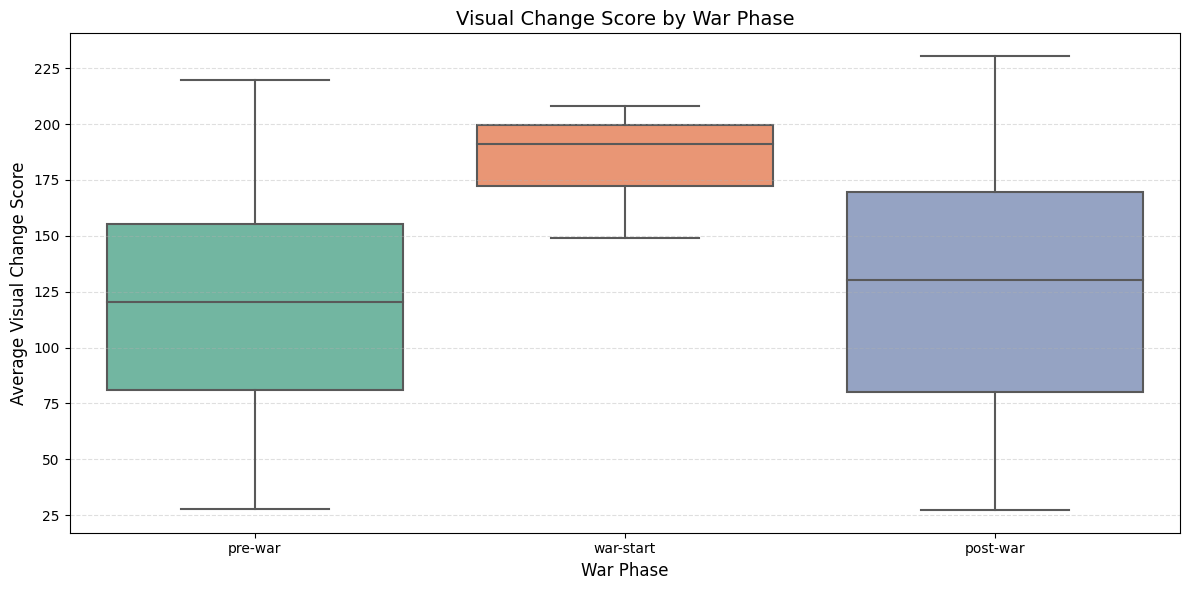

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='phase', y='change_score', data=final_df, palette='Set2')
plt.title("Visual Change Score by War Phase", fontsize=14)
plt.xlabel("War Phase", fontsize=12)
plt.ylabel("Average Visual Change Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [13]:
meta_path = '/kaggle/input/gaza-before-and-after-2/Gaza Before and After/metadata/section_23_2023-01-01.json'

with open(meta_path, 'r') as f:
    metadata = json.load(f)

# Print keys and preview
print(metadata.keys())
print(json.dumps(metadata, indent=2)[:1000])

dict_keys(['timestamp', 'section_id', 'local_path', 'source', 'collection', 'bbox', 'date_range'])
{
  "timestamp": "2023-01-01",
  "section_id": "section_23",
  "local_path": "D:\\collage\\Gaza Before and After\\satellite-imagery-app\\../data\\images\\section_23\\2023-01-01.png",
  "source": "Sentinel Hub",
  "collection": "sentinel-2-l2a",
  "bbox": [
    34.2195,
    31.3792514,
    34.389208499999995,
    31.415103000000002
  ],
  "date_range": "2022-12-29 to 2023-01-04"
}


In [14]:
# ==============================
# 7. Load Coordinates Metadata
# ==============================
meta_path = "/kaggle/input/gaza-before-and-after-2/Gaza Before and After/metadata"

# Dictionary to collect latest bbox for each section
section_coords = {}

for filename in os.listdir(meta_path):
    if filename.endswith('.json'):
        try:
            with open(os.path.join(meta_path, filename), 'r') as f:
                data = json.load(f)
                if 'bbox' in data:
                    section = data['section_id']
                    bbox = data['bbox']
                    if section not in section_coords:
                        section_coords[section] = {
                            'section': section,
                            'min_lon': bbox[0],
                            'min_lat': bbox[1],
                            'max_lon': bbox[2],
                            'max_lat': bbox[3]
                        }
        except:
            continue

In [ ]:
# ==============================
# 8. War Damage Visualization Map
# ==============================
# Filter for only relevant war periods
war_damage_df = final_df[final_df['phase'].isin(['war-start', 'post-war'])]

# Group by section, get the maximum damage score observed during/after war
max_damage_df = war_damage_df.groupby('section')['change_score'].max().reset_index()
max_damage_df.rename(columns={'change_score': 'max_damage_score'}, inplace=True)

# Merge with coordinates
map_df = max_damage_df.merge(coords_df, on='section', how='left').dropna()

# Create folium map
center_lat = map_df['min_lat'].mean()
center_lon = map_df['min_lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='OpenStreetMap')

# Color scale based on damage
colormap = linear.YlOrRd_09.scale(map_df['max_damage_score'].min(), map_df['max_damage_score'].max())

# Draw rectangles per section
for _, row in map_df.iterrows():
    bounds = [(row['min_lat'], row['min_lon']), (row['max_lat'], row['max_lon'])]
    Rectangle(
        bounds=bounds,
        color=None,
        fill=True,
        fill_color=colormap(row['max_damage_score']),
        fill_opacity=0.7,
        tooltip=f"{row['section']} | Max War Damage: {row['max_damage_score']:.1f}"
    ).add_to(m)
    
# List of major cities with lat/lon
city_labels = [
    {"name": "Gaza", "lat": 31.5, "lon": 34.47},
    {"name": "Rafah", "lat": 31.29, "lon": 34.25},
    {"name": "Khan Yunis", "lat": 31.34, "lon": 34.30},
    {"name": "Jabalia", "lat": 31.54, "lon": 34.50},
    {"name": "Beit Hanoun", "lat": 31.55, "lon": 34.55},
]

# Add city name labels
for city in city_labels:
    folium.Marker(
        location=[city['lat'], city['lon']],
        icon=folium.DivIcon(html=f"""<div style="font-size:12px; color:black;"><b>{city['name']}</b></div>""")
    ).add_to(m)

# Add color legend
colormap.caption = "Max War-Time Visual Damage per Section"
colormap.add_to(m)

m